# Convolutional Gaussian Processes
Mark van der Wilk (July 2019)

Here we show a simple example of the rectangles experiment, where we compare a normal SE GP, and a convolutional GP. This is similar to the experiment in [1].

[1] Van der Wilk, Rasmussen, Hensman (2017). Convolutional Gaussian Processes. *Advances in Neural Information Processing Systems 30*.

## Generate dataset
Generate a simple dataset of rectangles. We want to classify whether they are tall or wide. Note that here we take some care to make sure that the rectangles don't touch the edge, which is different to the original paper. We do this to avoid needing to use patch weights, which are needed to correctly account for edge effects.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
import time
import os

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_summary_fmt("notebook")

def is_continuous_integration():
    return os.environ.get('CI', None) is not None

MAXITER = 2 if is_continuous_integration() else 1000
NUM_TRAIN_DATA = 5 if is_continuous_integration() else 100
NUM_TEST_DATA = 7 if is_continuous_integration() else 300

In [2]:
def make_rectangle(arr, x0, y0, x1, y1):
    arr[y0:y1, x0] = 1
    arr[y0:y1, x1] = 1
    arr[y0, x0:x1] = 1
    arr[y1, x0:x1+1] = 1
    
def make_random_rectangle(arr):
    x0 = np.random.randint(1, arr.shape[1] - 3)
    y0 = np.random.randint(1, arr.shape[0] - 3)
    x1 = np.random.randint(x0 + 2, arr.shape[1] - 1)
    y1 = np.random.randint(y0 + 2, arr.shape[0] - 1)
    make_rectangle(arr, x0, y0, x1, y1)
    return x0, y0, x1, y1
    
def make_rectangles_dataset(num, w, h):
    d, Y = np.zeros((num, h, w)), np.zeros((num, 1))
    for i, img in enumerate(d):
        for j in range(1000):  # Finite number of tries tries
            x0, y0, x1, y1 = make_random_rectangle(img)
            rw, rh = y1 - y0, x1 - x0
            if rw == rh:
                img[:, :] = 0
                continue
            Y[i, 0] = rw > rh
            break
    return d.reshape(num, w * h).astype(gpflow.config.default_float()), Y.astype(gpflow.config.default_float())

In [3]:
X, Y = make_rectangles_dataset(NUM_TRAIN_DATA, 28, 28)
Xt, Yt = make_rectangles_dataset(NUM_TEST_DATA, 28, 28)

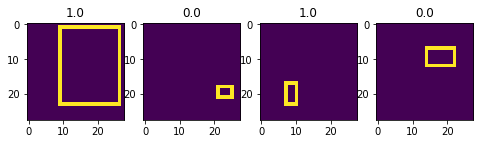

In [4]:
plt.figure(figsize=(8, 3))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X[i, :].reshape(28, 28))
    plt.title(Y[i, 0])

## Squared Exponential kernel

In [5]:
rbf_m = gpflow.models.SVGP(gpflow.kernels.SquaredExponential(), gpflow.likelihoods.Bernoulli(),
                           gpflow.inducing_variables.InducingPoints(X.copy()))

W0925 13:07:27.938622 4532037056 deprecation.py:323] From //anaconda/envs/tf2/lib/python3.7/site-packages/tensorflow_probability/python/internal/distribution_util.py:1846: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
rbf_m_log_likelihood = rbf_m.log_likelihood
print("RBF elbo before training: %.2e" % rbf_m_log_likelihood(X, Y))
rbf_m_log_likelihood = tf.function(rbf_m_log_likelihood)

RBF elbo before training: -9.94e+01


In [7]:
gpflow.utilities.set_trainable(rbf_m.inducing_variables, False)
start_time = time.time()
res = gpflow.optimizers.Scipy().minimize(lambda: -rbf_m_log_likelihood(X, Y), variables=rbf_m.trainable_variables,
                                         method="l-bfgs-b", options={"disp": True, "maxiter": MAXITER})
print(f"{res.nfev / (time.time() - start_time):.3f} iter/s")

W0925 13:07:29.699208 4532037056 ag_logging.py:145] Entity <bound method Dispatcher.dispatch_iter of <dispatched conditional>> appears to be a generator function. It will not be converted by AutoGraph.


W0925 13:07:30.688961 4532037056 ag_logging.py:145] Entity <bound method Dispatcher.dispatch_iter of <dispatched Kuf>> appears to be a generator function. It will not be converted by AutoGraph.


8.703 iter/s


In [8]:
train_err = np.mean((rbf_m.predict_y(X)[0] > 0.5).numpy().astype('float') == Y)
test_err = np.mean((rbf_m.predict_y(Xt)[0] > 0.5).numpy().astype('float') == Yt)

In [9]:
print(f"Train acc: {train_err * 100}%\nTest acc : {test_err*100}%")
print("RBF elbo after training: %.2e" % rbf_m_log_likelihood(X, Y))

Train acc: 100.0%
Test acc : 66.33333333333333%
RBF elbo after training: -6.62e+01


## Convolutional kernel

In [10]:
f64 = lambda x: np.array(x, dtype=np.float64)
positive_with_min = lambda: tfp.bijectors.AffineScalar(shift=f64(1e-4))(tfp.bijectors.Softplus())
constrained = lambda: tfp.bijectors.AffineScalar(shift=f64(1e-4), scale=f64(100.0))(tfp.bijectors.Sigmoid())
conv_k = gpflow.kernels.Convolutional(gpflow.kernels.SquaredExponential(), [28, 28], [3, 3])
conv_k.basekern.lengthscale = gpflow.Parameter(1.0, transform=positive_with_min())
conv_k.basekern.variance = gpflow.Parameter(1.0, transform=constrained())
conv_f = gpflow.inducing_variables.InducingPatches(np.unique(conv_k.get_patches(X).numpy().reshape(-1, 9), axis=0))

In [11]:
conv_m = gpflow.models.SVGP(conv_k, gpflow.likelihoods.Bernoulli(), conv_f)

In [12]:
gpflow.utilities.set_trainable(conv_m.inducing_variables, False)
conv_m.kernel.basekern.variance.trainable = False
conv_m.kernel.weights.trainable = False

In [13]:
conv_m_log_likelihood = conv_m.log_likelihood
print("conv elbo before training: %.2e" % conv_m_log_likelihood(X, Y))
conv_m_log_likelihood = tf.function(conv_m_log_likelihood)

conv elbo before training: -9.39e+01


In [14]:
start_time = time.time()
res = gpflow.optimizers.Scipy().minimize(lambda: -conv_m_log_likelihood(X, Y), variables=conv_m.trainable_variables,
                                      method="l-bfgs-b", options={"disp": True, "maxiter": MAXITER / 10})
print(f"{res.nfev / (time.time() - start_time):.3f} iter/s")

W0925 13:07:36.058125 4532037056 ag_logging.py:145] Entity <bound method Dispatcher.dispatch_iter of <dispatched conditional>> appears to be a generator function. It will not be converted by AutoGraph.
W0925 13:07:36.189826 4532037056 ag_logging.py:145] Entity <bound method Dispatcher.dispatch_iter of <dispatched Kuf>> appears to be a generator function. It will not be converted by AutoGraph.


0.611 iter/s


In [ ]:
conv_m.kernel.basekern.variance.trainable = True
start_time = time.time()
res = gpflow.optimizers.Scipy().minimize(lambda: -conv_m.log_likelihood(X, Y), variables=conv_m.trainable_variables,
                                      method="l-bfgs-b", options={"disp": True, "maxiter": MAXITER})

In [ ]:
print(f"Train acc: {train_err * 100}%\nTest acc : {test_err*100}%")
print("conv elbo after training: %.2e" % conv_m_log_likelihood(X, Y))

In [ ]:
conv_m.kernel.weights.trainable = True
start_time = time.time()
res = gpflow.optimizers.Scipy().minimize(lambda: -conv_m.log_likelihood(X, Y), variables=conv_m.trainable_variables,
                                      method="l-bfgs-b", options={"disp": True, "maxiter": MAXITER})

In [ ]:
train_err = np.mean((conv_m.predict_y(X)[0] > 0.5).numpy().astype('float') == Y)
test_err = np.mean((conv_m.predict_y(Xt)[0] > 0.5).numpy().astype('float') == Yt)

In [ ]:
print(f"Train acc: {train_err * 100}%\nTest acc : {test_err*100}%")
print("conv elbo after training: %.2e" % conv_m_log_likelihood(X, Y))

In [ ]:
gpflow.utilities.print_summary(rbf_m)

In [ ]:
gpflow.utilities.print_summary(conv_m)

## Conclusion
The convolutional kernel performs much better in this simple task. It demonstrates non-local generalisation of the strong assumptions in the kernel.